In [1]:
import numpy as np
from scipy import signal
import math
import matplotlib.pyplot as plt
from matplotlib import rcParams

Create a directory to store data

In [1]:
!mkdir -p data

### Generate source time function (Ricker wavelet)

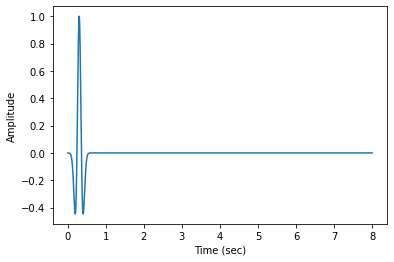

In [3]:
nt=2001
dt=0.004
ot=0
wc=0.03
sigma=math.sqrt(2)/(math.pi*wc)
src = signal.ricker(2*nt-1, sigma)
src=src[1925:1925+nt]
src=src*1.0/np.max(src)

plt.plot(np.linspace(ot,(nt-1)*dt,nt),src)
plt.xlabel("Time (sec)")
plt.ylabel("Amplitude")
plt.show()

In [4]:
# save to numpy
np.save('./data/wavelet',src)

# convert to SEPlib
!python ../local/bin/sep2numpy.py --input ./data/wavelet.npy --mode 1 --datapath ${PWD}/data/ --output ./data/wavelet.H

# set the sampling (in sec) in the description file
!echo d1=0.004 >> ./data/wavelet.H

### Generate a simple elastic VTI model

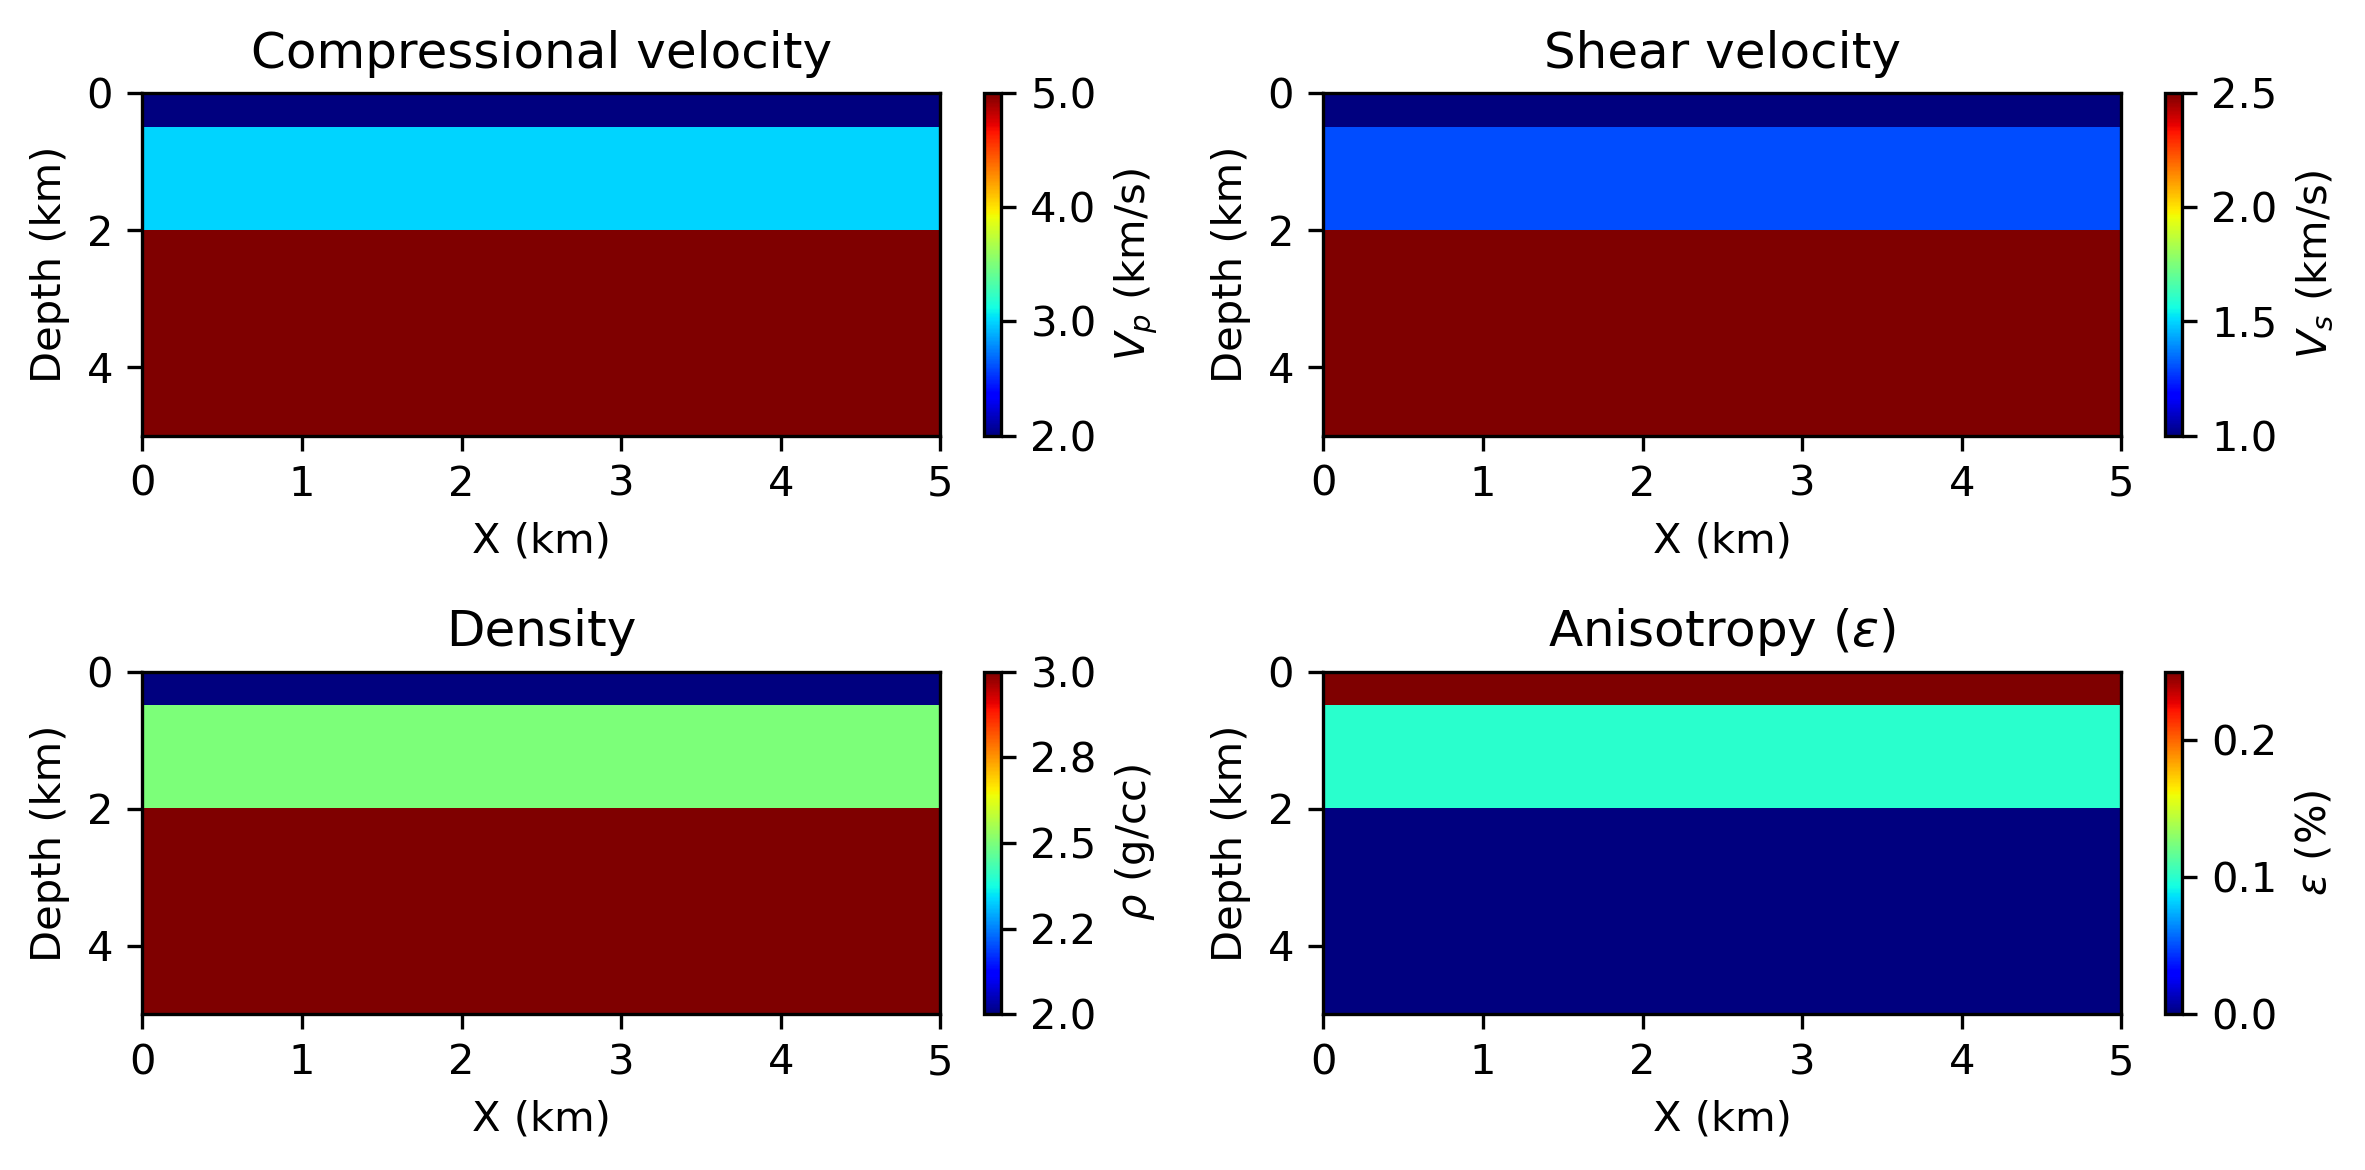

In [5]:
emodel=np.zeros((5,501,501))
emodel[0,:,0:50]=2. # Vp in km/s
emodel[0,:,50:200]=3.
emodel[0,:,200:]=5.
emodel[1,:,0:50]=1 # Vs in km/s
emodel[1,:,50:200]=1.3
emodel[1,:,200:]=2.5
emodel[2,:,0:50]=2. # Density in g/cc
emodel[2,:,50:200]=2.5
emodel[2,:,200:]=3.
emodel[3,:,0:50]=0.15 # Delta in % (Thomsen parameters)
emodel[3,:,50:200]=0.075
emodel[3,:,200:]=0.
emodel[4,:,0:50]=0.25 # Epsilon in % (Thomsen parameters)
emodel[4,:,50:200]=0.1
emodel[4,:,200:]=0.

plt.figure(figsize=(8,4),dpi=300)
plt.subplot(2,2,1)
plt.imshow(np.transpose(emodel[0,:,:]),interpolation='none',aspect="auto",extent=[0,5,5,0],cmap='jet')
plt.xlabel('X (km)')
plt.ylabel('Depth (km)')
plt.colorbar(fraction=0.04, format='%.'+str(1)+'f',label=r'$V_p$ (km/s)')
plt.title("Compressional velocity")

plt.subplot(2,2,2)
plt.imshow(np.transpose(emodel[1,:,:]),interpolation='none',aspect="auto",extent=[0,5,5,0],cmap='jet')
plt.xlabel('X (km)')
plt.ylabel('Depth (km)')
plt.colorbar(fraction=0.04, format='%.'+str(1)+'f',label=r'$V_s$ (km/s)')
plt.title("Shear velocity")

plt.subplot(2,2,3)
plt.imshow(np.transpose(emodel[2,:,:]),interpolation='none',aspect="auto",extent=[0,5,5,0],cmap='jet')
plt.xlabel('X (km)')
plt.ylabel('Depth (km)')
plt.colorbar(fraction=0.04, format='%.'+str(1)+'f',label=r'$\rho$ (g/cc)')
plt.title("Density")

plt.subplot(2,2,4)
plt.imshow(np.transpose(emodel[4,:,:]),interpolation='none',aspect="auto",extent=[0,5,5,0],cmap='jet')
plt.xlabel('X (km)')
plt.ylabel('Depth (km)')
plt.colorbar(fraction=0.04, format='%.'+str(1)+'f',label=r'$\epsilon$ (%)')
plt.title(r'Anisotropy ($\epsilon$)')

plt.tight_layout()

In [6]:
# save the model in numpy
np.save("./data/emodel",emodel)

# convert to SEPlib
!python ../local/bin/sep2numpy.py --input ./data/emodel.npy --mode 1 --datapath ${PWD}/data/ --output ./data/emodel.H

# set the sampling (in km) in the description file
! echo d1=0.01 >> ./data/emodel.H
! echo d2=0.01 >> ./data/emodel.H

### Forward modeling
The modeling parameters can be provided via a parameter file (as below) but they can also be given directly inline. A combination of the two is also admissible but the command line arguments will override the parameter file if the same parameter is provided in both. Check the parameter file for a description of each parameter. Input and output files must be provided directly inline. The full wavefield can also be output.

The log information can be saved into a file. By default it will print to the command line.

In [7]:
# peek into the parameter file
!cat ./par/elastic_modeling.p

# time parameters
courant=0.6
dt=-1
fmax=10
resampling=sinc
sinc_half_length=11
sub=0

# sources and receivers geometry
srcoord=./par/srcoord.txt

# source mechanism and receiver type
mt=1
fangle=0
mxx=0
mzz=0
mxz=1
seismotype=1
gl=0

# boundary parameters
bc_top=1
bc_bottom=2
bc_left=2
bc_right=2
taper_top=0
taper_left=30
taper_right=30
taper_bottom=30
taper_strength=0.05

# model bounds
vpmin=0.2
vpmax=8
vsmin=0.1
vsmax=5
rhomin=0 
rhomax=8
deltamin=-0.5
deltamax=1
epsilonmin=0
epsilonmax=1

# miscallenous
device=0
nthreads=24
verbose=3
format=0

In [8]:
# run the modeling of particle velocity receivers
!../local/bin/WE_MODELING.x source=./data/wavelet.H model=./data/emodel.H output=./data/elastic_data.H datapath=${PWD}/data/ parfile=./par/elastic_modeling.p


 Subsurface model geometry
xmin=0.00000 km, xmax=5.00000 km, dx=0.01000 km, nx=501
zmin=0.00000 km, zmax=5.00000 km, dz=0.01000 km, nz=501

 Boundary conditions
Top boundary condition = free surface	 taper size = 0	 taper type = none
Bottom boundary condition = locally absorbing	 taper size = 30	 taper type = cosine squared
Left boundary condition = locally absorbing	 taper size = 30	 taper type = cosine squared
Right boundary condition = locally absorbing	 taper size = 30	 taper type = cosine squared

 Sources' and receivers' geometry
Sources' and receivers' coordinates are read from file ./par/srcoord.txt
Receivers are point measurement of type particle velocity
Number of sources = 2
Shot 0 located at x=2.50000 km, z=3.50000 km, has 5 receivers
Shot 1 located at x=1.50000 km, z=4.00000 km, has 5 receivers
Total number of 2-components receivers to be modeled = 10

 Source wavelet
Moment tensor is assumed with mxx=0.000000, mzz=0.000000, mxz=1.000000
Input wavelet will be duplicated 3

In [9]:
# run the modeling of DAS data (strain rate every meter with 10 m gauge length) at the surface
!../local/bin/WE_MODELING.x source=./data/wavelet.H model=./data/emodel.H output=./data/das_data.H datapath=${PWD}/data/ parfile=./par/das_modeling.p


 Subsurface model geometry
xmin=0.00000 km, xmax=5.00000 km, dx=0.01000 km, nx=501
zmin=0.00000 km, zmax=5.00000 km, dz=0.01000 km, nz=501

 Boundary conditions
Top boundary condition = free surface	 taper size = 0	 taper type = none
Bottom boundary condition = locally absorbing	 taper size = 30	 taper type = cosine squared
Left boundary condition = locally absorbing	 taper size = 30	 taper type = cosine squared
Right boundary condition = locally absorbing	 taper size = 30	 taper type = cosine squared

 Sources' and receivers' geometry
Sources' and receivers' coordinates are read from parameters list
Receivers are DAS measurement of type strain rate with gauge length = 0.010000 km
Number of sources = 1
Shot 0 located at x=2.50000 km, z=3.50000 km, has 1001 receivers
Total number of DAS channels to be modeled = 1001

 Source wavelet
Moment tensor is assumed with mxx=0.000000, mzz=0.000000, mxz=1.000000
Input wavelet will be duplicated 3 x 1 times with the appropriate scaling
Parameter 

In [10]:
# convert to numpy, load, and plot
!python ../local/bin/sep2numpy.py --input ./data/elastic_data.H --output ./data/elastic_data
!python ../local/bin/sep2numpy.py --input ./data/das_data.H --output ./data/das_data

edata=np.load("./data/elastic_data.npy")
dasdata=np.load("./data/das_data.npy")

edata=np.reshape(edata,(2,2,5,nt)) # 2 shots, 2 components, 5 receivers, nt time samples

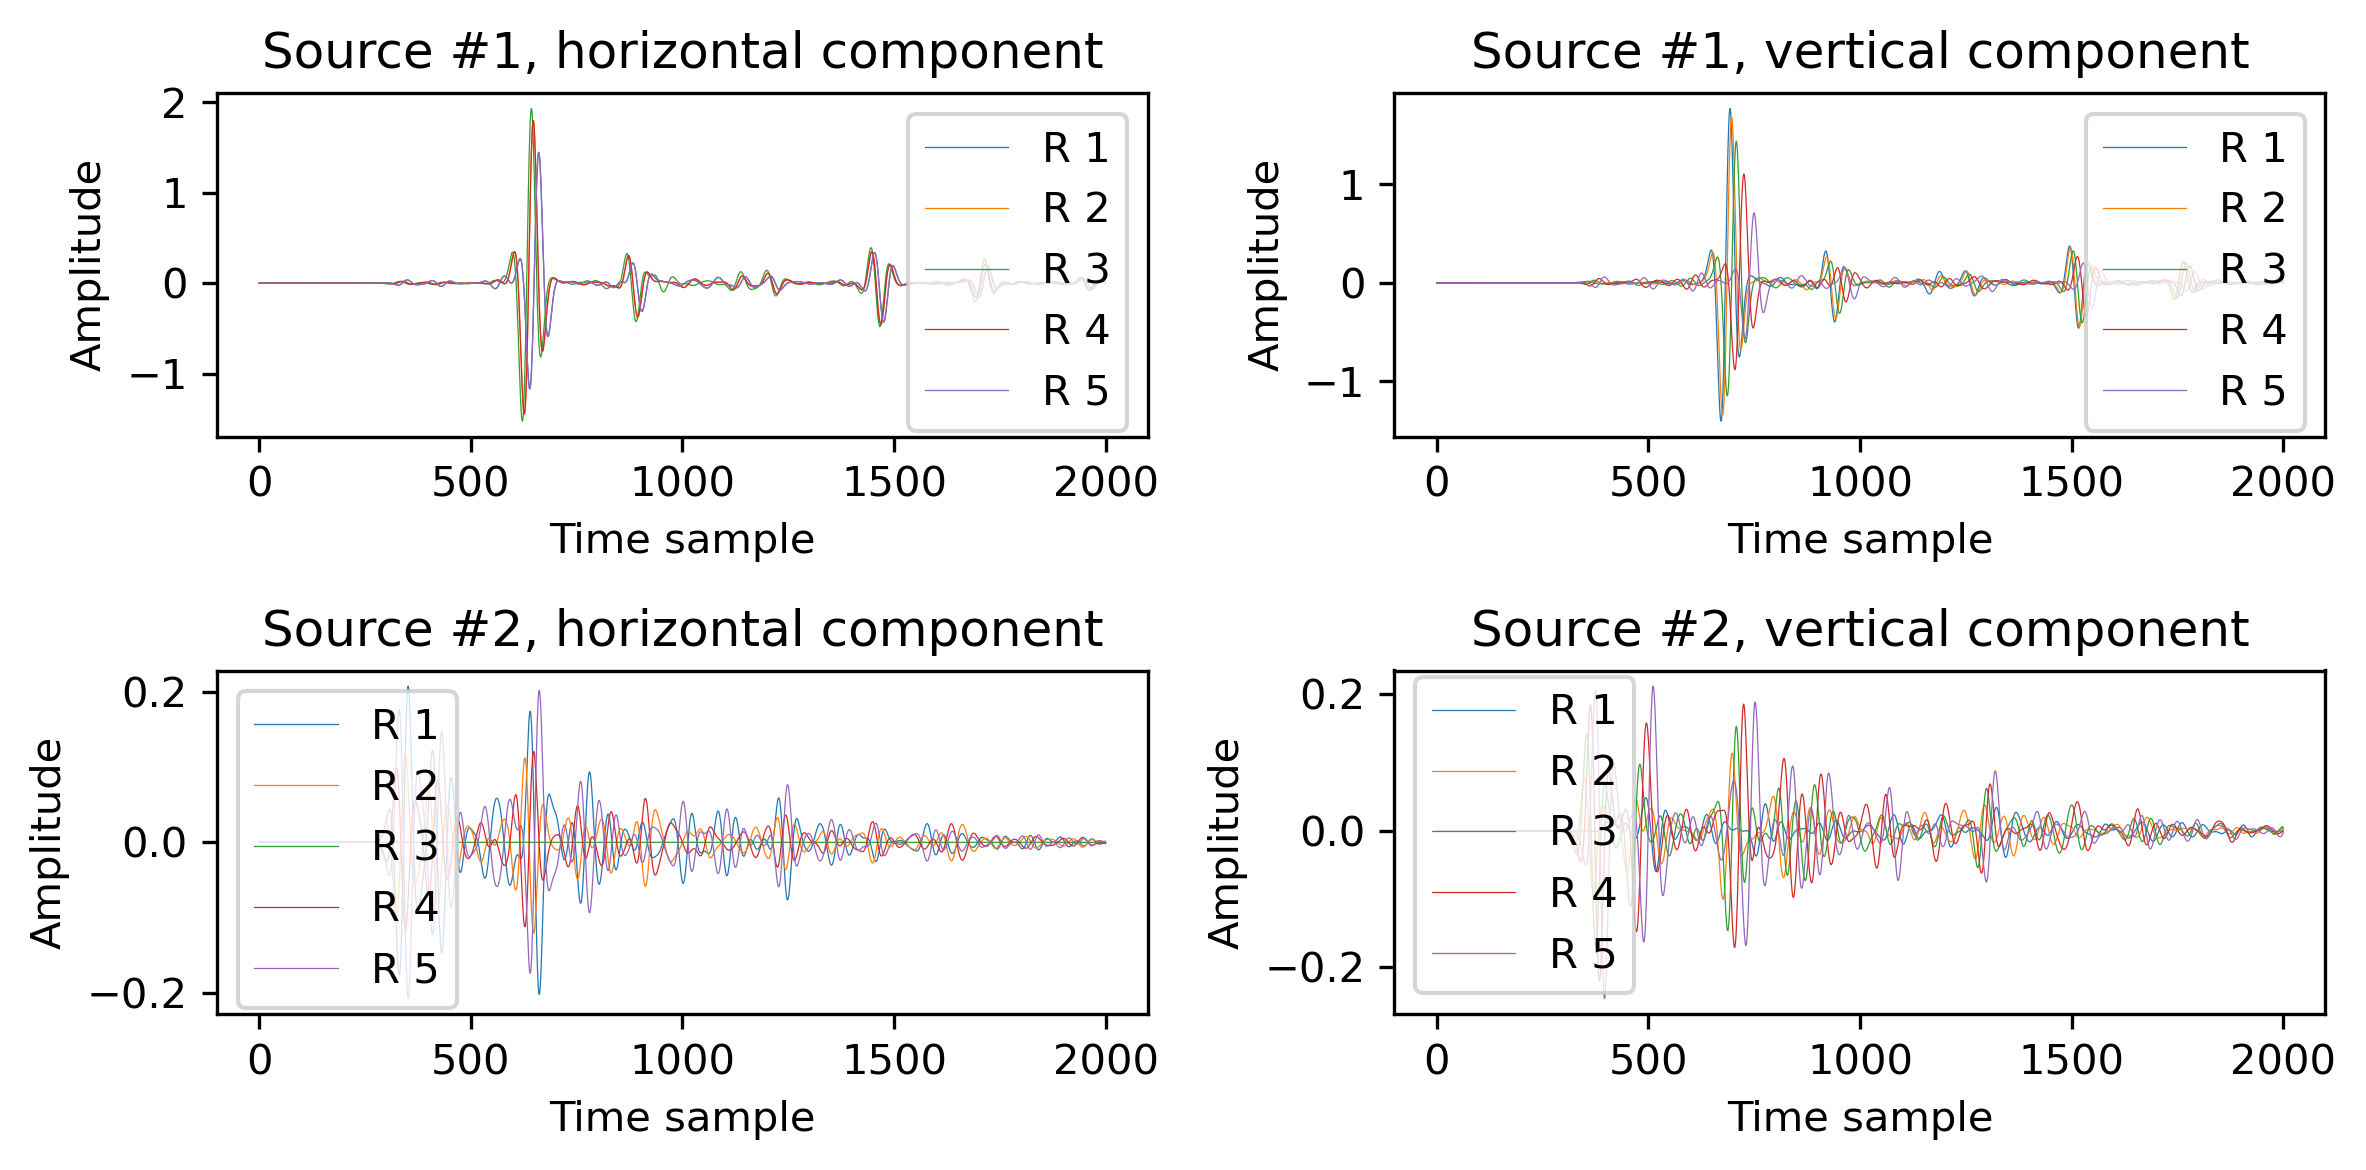

In [11]:
plt.figure(figsize=(8,4),dpi=300)
plt.subplot(2,2,1)
for i in range(5):
    label="R "+str(i+1)
    plt.plot(edata[0,0,i,:],LineWidth=0.3,label=label)
plt.legend()
plt.xlabel('Time sample')
plt.ylabel('Amplitude')
plt.title("Source #1, horizontal component")

plt.subplot(2,2,2)
for i in range(5):
    label="R "+str(i+1)
    plt.plot(edata[0,1,i,:],LineWidth=0.3,label=label)
plt.legend()
plt.xlabel('Time sample')
plt.ylabel('Amplitude')
plt.title("Source #1, vertical component")

plt.subplot(2,2,3)
for i in range(5):
    label="R "+str(i+1)
    plt.plot(edata[1,0,i,:],LineWidth=0.3,label=label)
plt.legend()
plt.xlabel('Time sample')
plt.ylabel('Amplitude')
plt.title("Source #2, horizontal component")

plt.subplot(2,2,4)
for i in range(5):
    label="R "+str(i+1)
    plt.plot(edata[1,1,i,:],LineWidth=0.3,label=label)
plt.legend()
plt.xlabel('Time sample')
plt.ylabel('Amplitude')
plt.title("Source #2, vertical component")

plt.tight_layout()

Text(0.5, 1.0, 'DAS data')

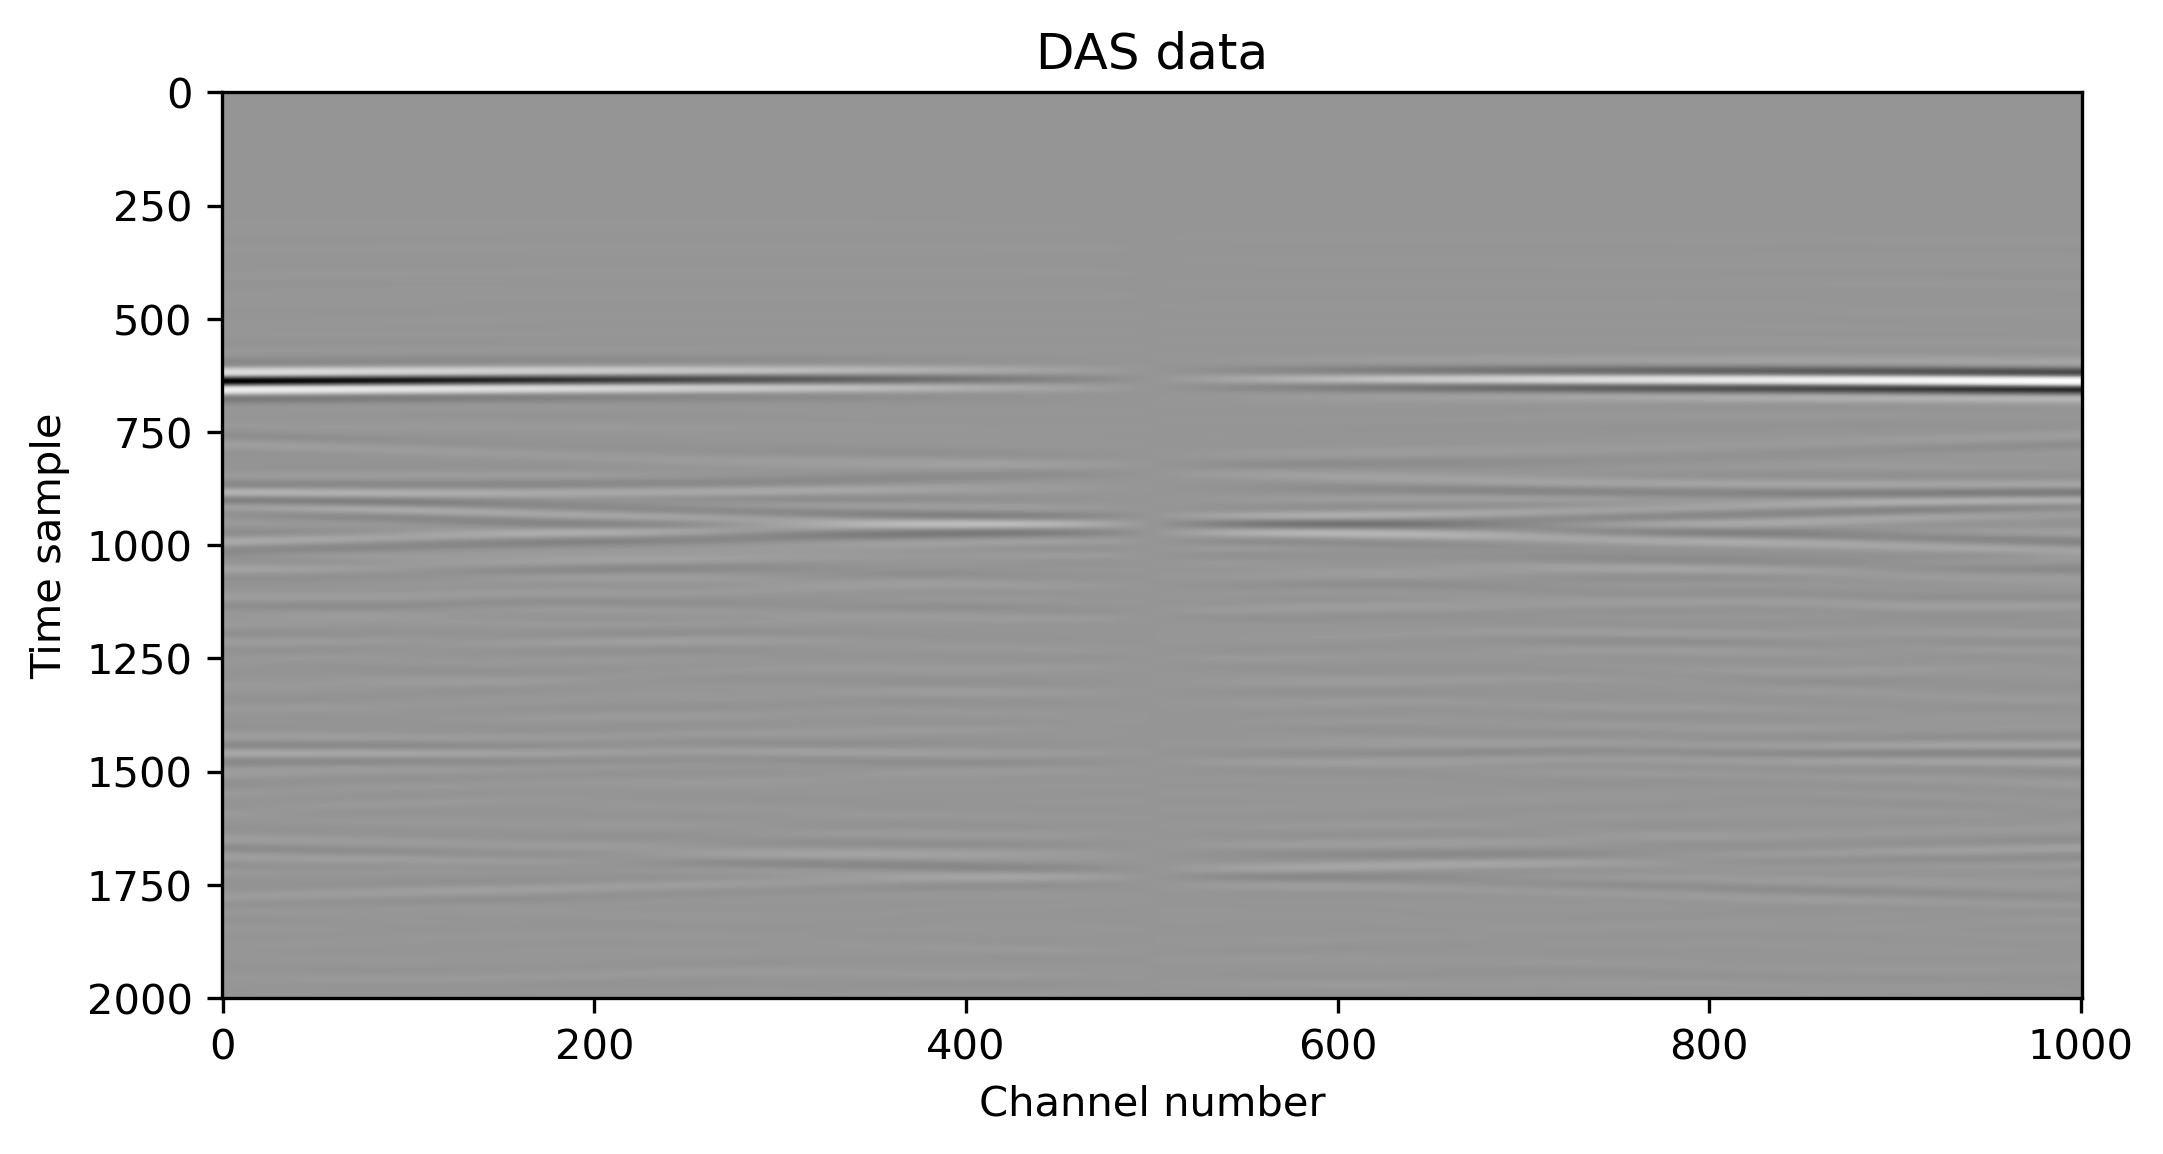

In [12]:
plt.figure(figsize=(8,4),dpi=300)
plt.imshow(np.transpose(dasdata[:,:]),interpolation='bilinear',aspect="auto",cmap='Greys')
plt.xlabel('Channel number')
plt.ylabel('Time sample')
plt.title("DAS data")

Clean up the data directory

In [13]:
!rm -rf data